# Aprendizado de Máquina - Projeto 3: Vulcões na Superfície de Vênus

### Aluno: Kaio Alvim; Professor: Hugo Carvalho

### A base de dados contém 7000 imagens da superfície de vênus, indicadas com um rótulo da existência de vulcões e caso haja, o raio do vulcão, quantidade de vulcões na imagem e uma variável que codifica a incerteza sobre a existência do vulcão.

### Objetivo: Treinar os modelos vistos em sala de aula para classificar se há ou não vulcões em cada uma das imagens da base de dados. (Não era perimitido o uso de redes neurais)



# Setup

In [ ]:
#Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import data, filters
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
feat = pd.read_csv('/content/drive/MyDrive/train_images.csv', header = None)
resp = pd.read_csv('/content/drive/MyDrive/train_labels.csv')

x_tt = pd.read_csv('/content/drive/MyDrive/test_images.csv', header = None)
y_tt = pd.read_csv('/content/drive/MyDrive/test_labels.csv')

In [ ]:
feat.head()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


In [ ]:
#Vamos padronizar os dados para trabalharmos no intervalo entre 0 e 1
#RODAR SOMENTE UMA VEZ

feat = feat / 255
x_tt = x_tt / 255

In [ ]:
feat.describe()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,0.392094,0.392081,0.392210,0.392055,0.392471,0.392829,0.392390,0.392891,0.394323,0.394095,...,0.393148,0.394229,0.394468,0.393671,0.393280,0.393461,0.393872,0.394087,0.392729,0.392283
std,0.103921,0.103588,0.103561,0.103686,0.103978,0.103971,0.104436,0.103945,0.103757,0.104617,...,0.099895,0.099796,0.099251,0.098767,0.098417,0.099230,0.099613,0.099269,0.098508,0.098728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,...,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098,0.345098
50%,0.396078,0.396078,0.396078,0.396078,0.396078,0.396078,0.396078,0.396078,0.396078,0.396078,...,0.396078,0.396078,0.396078,0.396078,0.392157,0.392157,0.396078,0.396078,0.392157,0.392157
75%,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.454902,0.450980,...,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.450980,0.447059,0.447059
max,0.745098,0.729412,0.729412,0.737255,0.752941,0.749020,0.772549,0.792157,0.792157,0.768627,...,0.780392,0.745098,0.721569,0.705882,0.713725,0.694118,0.713725,0.725490,0.701961,0.709804


# Análise Exploratória

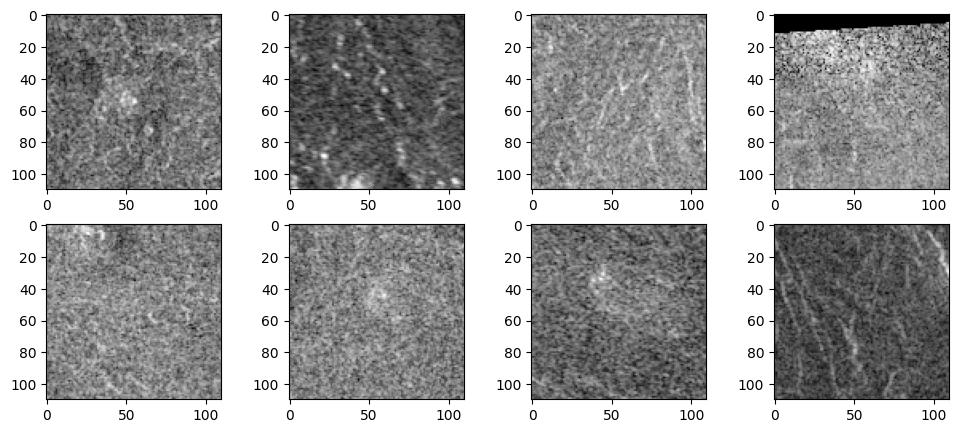

In [ ]:
#Vendo algumas imagens na base de dados
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = np.array(feat.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

In [ ]:
#Entendendo a variável resposta
resp.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


* Se ``Volcano? = 0``, então na respectiva imagem acredita-se fortemente que **não** há um vulcão
* Se ``Volcano? = 1``, então acredita-se fortemente que naquela imagem há ao menos um vulcão (nesse caso, há um vulcão centralizado na figura).
   - ``Number Volcanoes`` representa quantos vulcões provavelmente há naquela imagem
   - ``Radius`` é o raio do vulcão que está centralizado na imagem, medido em *pixels*
   - ``Type`` é uma variável que codifica a incerteza dos astrônomos sobre a existência de um vulcão naquela imagem:
     - ``Type = 1`` indica que a figura respectiva CERTAMENTE contém ao menos um vulcão
     - ``Type = 2`` indica que a figura respectiva PROVAVELMENTE contém ao menos um vulcão
     - ``Type = 3`` indica que a figura respectiva POSSIVELMENTE contém ao menos um vulcão
     - ``Type = 4`` indica que a figura respectiva mostra somente uma cratera

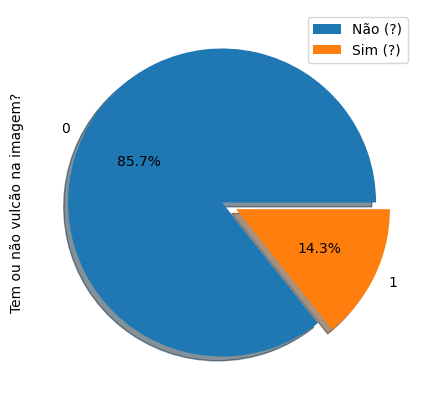

In [ ]:
#Note que a base de dados está desbalanceada
resp['Volcano?'].value_counts().plot(
    kind = 'pie', explode = [0, 0.1], figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.ylabel('Tem ou não vulcão na imagem?')
plt.legend(['Não (?)', 'Sim (?)'])
plt.show()

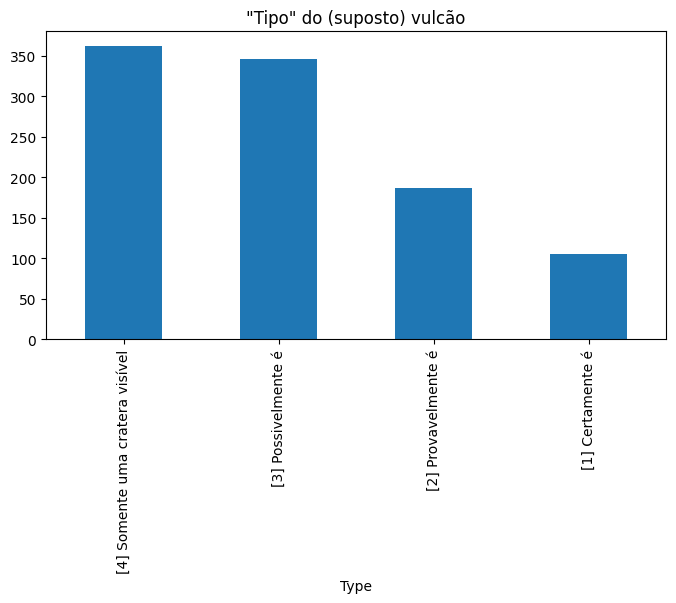

In [ ]:
#Dentre as imagens que acredita-se ter um vulcão, vamos ver a distribuição dos quatro graus de incerteza possíveis:
resp[resp['Volcano?'] == 1]['Type'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.title('"Tipo" do (suposto) vulcão')
plt.xticks(np.arange(4), ['[4] Somente uma cratera visível', '[3] Possivelmente é', '[2] Provavelmente é', '[1] Certamente é'])
plt.show()

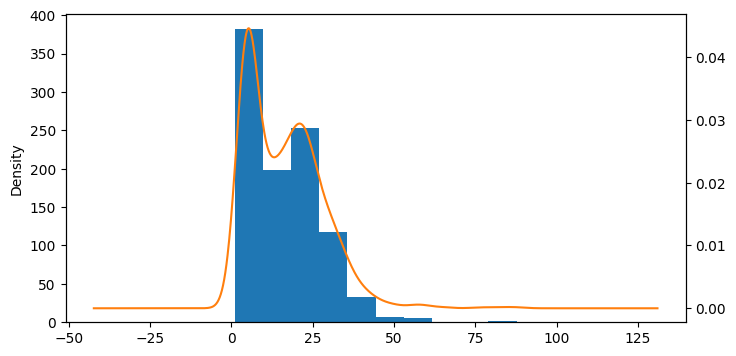

In [ ]:
#Temos uma variável resposta contínua, que é o raio do vulcão:
ax = resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'hist', legend = False, figsize = (8, 4))
resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'kde', ax = ax, secondary_y = True)
plt.show()

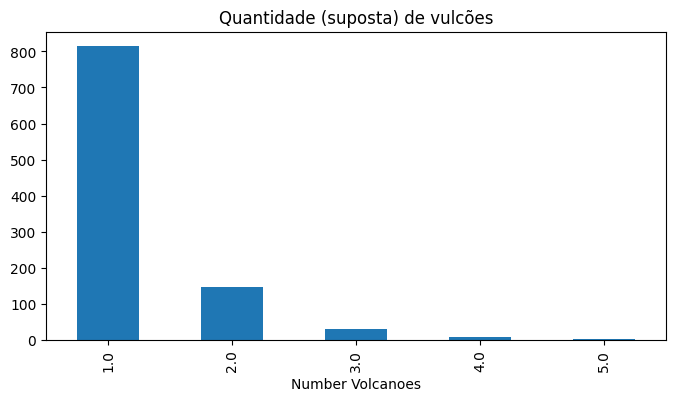

In [ ]:
#Quantidade suposta de vulcões na imagem
plt.title('Quantidade (suposta) de vulcões')
resp[resp['Volcano?'] == 1]['Number Volcanoes'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.show()

== IMAGEM SEM VULCÃO ==
Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 1, dtype: float64


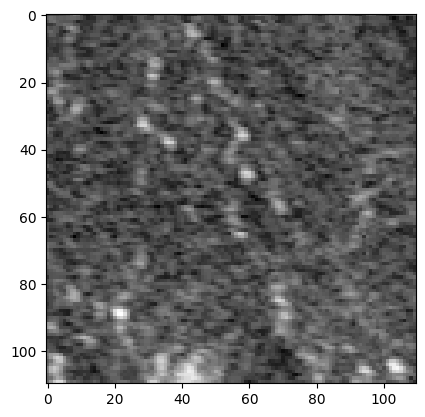

In [ ]:
print('== IMAGEM SEM VULCÃO ==')

print(resp.iloc[1])

image = np.array(feat.iloc[1]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 1.00
Radius              22.02
Number Volcanoes     1.00
Name: 9, dtype: float64


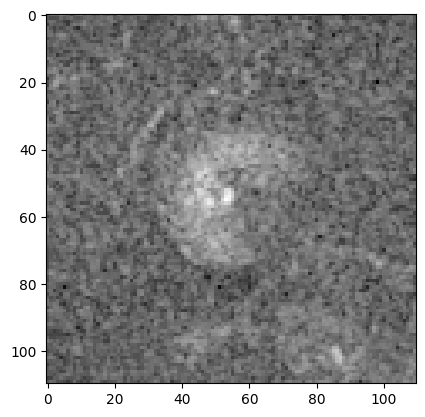

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[9])

image = np.array(feat.iloc[9]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

# Pré-processamento das imagens

Iremos fazer alguns ajustes na imagem a fim de visualizar melhor as bordas e picos do vulcão. Isso ajudará imensamente na hora de treinar os modelos para classificação.

Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 10, dtype: float64


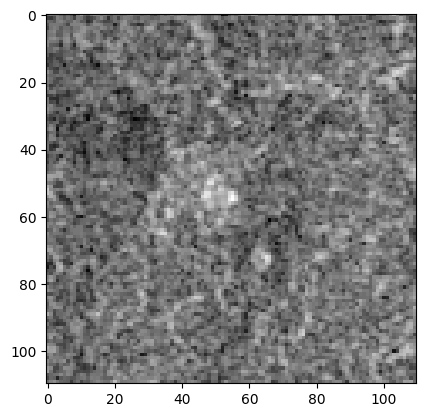

In [ ]:
print(resp.iloc[10])

image = np.array(feat.iloc[0]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

É dito que sempre que houver um vulcão ele estará no centro da imagem.

Então como a nossa base de treinamento tem 7000 imagens com 110x110 = 12100 pixels, ou seja, 84.700.000 dados, extremamente pesada de se trabalhar, vamos fazer um ajuste para cortar centralizadamente a imagem.

In [ ]:
#Cortando as imagens para o tamanho 20x20
def cortar(linha):
  linha_cortada = np.array(linha).reshape((110,110))[45:65, 45:65]
  return linha_cortada

feat1 = feat.apply(cortar, axis =1)
x_tt1 = x_tt.apply(cortar, axis =1)
feat1.shape

(7000,)

Agora são 20x20 = 400 pixels e 2.800.000 dados, bem mais leve.

Faremos alguns testes de caso para uma das imagens (a primeira) com o objetivo de melhorar a qualidade dela, e no caso de êxito, generalizamos o processo para todo o dataframe

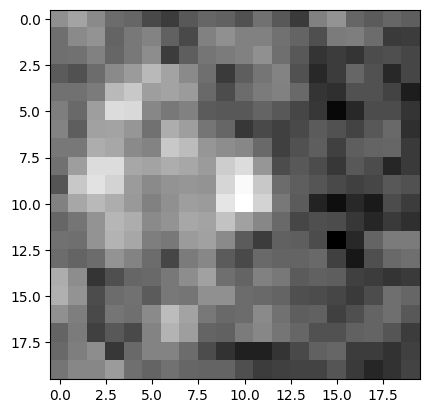

In [ ]:
plt.figure()
plt.imshow(feat1[0],cmap="gray")
plt.show()

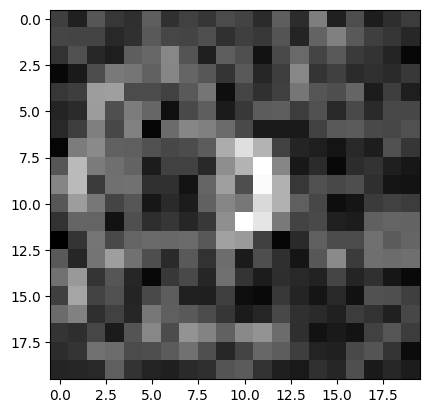

In [ ]:
#Vamos aplicar um filtro Sobel com o objetivo de ressaltar a borda da figura

edges = filters.sobel(feat1[0])

plt.figure()
plt.imshow(edges,cmap="gray")
plt.show()

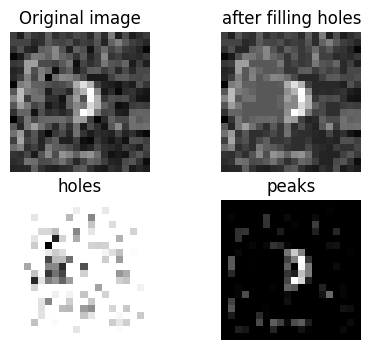

In [ ]:
#Agora, tentemos reconstruir a imagem a fim de achar o ponto máximo de altitude da figura

image = edges

seed = np.copy(image)
seed[1:-1, 1:-1] = image.max()
mask = image

filled = reconstruction(seed, mask, method='erosion')

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filled, cmap='gray')
ax[1].set_title('after filling holes')
ax[1].axis('off')

ax[2].imshow(image-filled, cmap='gray')
ax[2].set_title('holes')
ax[2].axis('off')

ax[3].imshow(image-rec, cmap='gray')
ax[3].set_title('peaks')
ax[3].axis('off')
plt.show()

Bem mais fácil visualizar o vulcão agora, não?

In [ ]:
#Apenas aplicando o procedimento em toda a base de dados
feat2 = pd.Series()
for i in range(0,7000):
  image = feat1[i]
  image = filters.sobel(image)
  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.max()
  mask = image

  filled = reconstruction(seed, mask, method='erosion')

  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.min()
  rec = reconstruction(seed, mask, method='dilation')

  feat2 = pd.concat([feat2, pd.Series([image-rec])], ignore_index=True)

<ipython-input-52-935e31cdfa37>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  feat2 = pd.Series()


In [ ]:
x_tt2 = pd.Series()
for i in range(0,2734):
  image = x_tt1[i]
  image = filters.sobel(image)
  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.max()
  mask = image

  filled = reconstruction(seed, mask, method='erosion')

  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.min()
  rec = reconstruction(seed, mask, method='dilation')

  x_tt2 = pd.concat([x_tt2, pd.Series([image-rec])], ignore_index=True)

<ipython-input-53-2a1ec1151e22>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  x_tt2 = pd.Series()


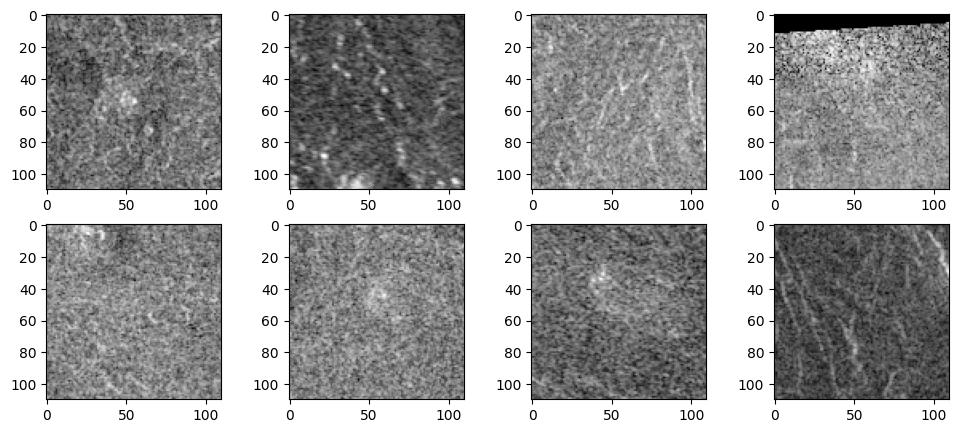

In [ ]:
#Imagens originais
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = np.array(feat.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

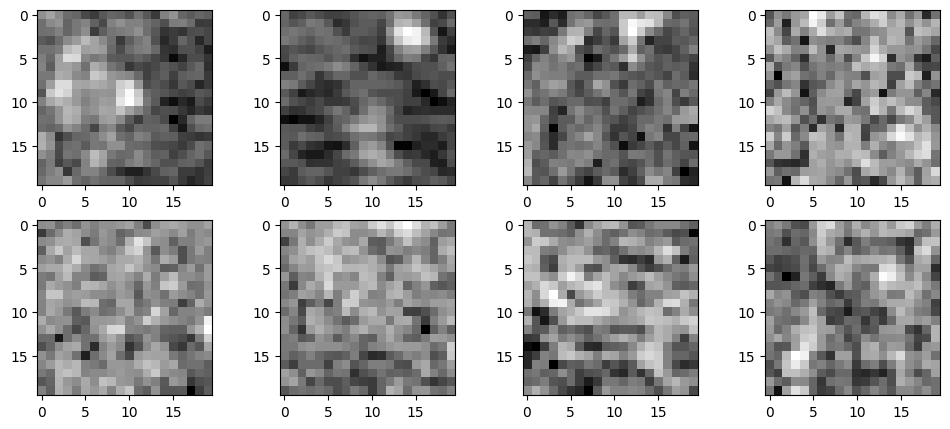

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = feat1[ind]
    ax.imshow(img, cmap = 'gray')
    ind += 1

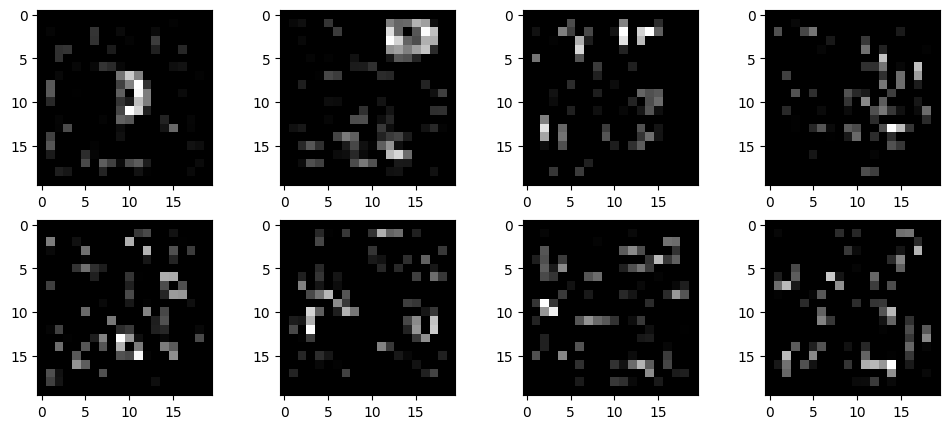

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = feat2[ind]
    ax.imshow(img, cmap = 'gray')
    ind += 1

In [ ]:
#Feito o processamento de imagens, o formato atual da base de dados não mais nos é conveniente. Vamos preparar o terreno.
dict = {}
for i in range(0,7000):
  linha = feat2[i].reshape(400)
  dict[i] = linha
X_train = (pd.DataFrame(dict)).transpose()

y_train = resp['Volcano?']

dict = {}
for i in range(0,2734):
  linha = x_tt2[i].reshape(400)
  dict[i] = linha
X_test = (pd.DataFrame(dict)).transpose()

y_test = y_tt['Volcano?']

# Classificação

Com uma base de dados mais leve e com imagens melhores, comecemos a classificação.

Aqui é importante ressaltarmos alguns pontos. Há 4 cenários para a classificação.


1. O modelo alega corretamente a existência de vulcão
2. O modelo alega corretamente a inexistência de vulcão
3. O modelo alega de forma errada a existência de um vulcão (Falso positivo)
4. O modelo alega de forma errada a inexistência de um vulcão (Falso Negativo)

Em determinados contextos podemos valorizar mais ou menos a baixa existência de falsos positivos em detrimento a falso negativos. Esse não será o nosso caso. Iremos prezar pelo balanço entre os dois, adotando como métrica favorita o F1 score. Além disso, testaremos todos os modelos e tiraremos as conclusões no final do relatório.


In [ ]:
Resultados = {'Modelo': [], 'F1 Score': [], 'Acurácia': [], 'FP': [], 'FN': []}

In [ ]:
#Usaremos o mesmo procedimento para as métricas do modelo extensivamente, por que não poupar um código?
def metricas(predicoes, modelo):
  CM_NB = metrics.confusion_matrix(y_test, predicoes)

  Pop = np.size(y_test)
  N = np.size(np.where(y_test == 0))
  P = np.size(np.where(y_test == 1))

  VN_NB = CM_NB[0, 0]
  FP_NB = CM_NB[0, 1]
  FN_NB = CM_NB[1, 0]
  VP_NB = CM_NB[1, 1]

  Prev = P/Pop
  Acc_NB = (VN_NB + VP_NB)/Pop

  FPR_NB = FP_NB/N
  TNR_NB = VN_NB/N
  TPR_NB = VP_NB/P
  FNR_NB = FN_NB/P

  FOR_NB = FN_NB/(VN_NB + FN_NB)
  PPV_NB = VP_NB/(FP_NB + VP_NB)
  NPV_NB = VN_NB/(VN_NB + FN_NB)
  FDR_NB = FP_NB/(FP_NB + VP_NB)

  F1_NB = 2/(1/PPV_NB + 1/TPR_NB)

  print('Prevalência:', Prev)
  print('Acurácia:', Acc_NB)
  print('Taxa de falsos positivos:', FPR_NB)
  print('Taxa de verdadeiros negativos (Especificidade):', TNR_NB)
  print('Taxa de verdadeiros positivos (Recall):', TPR_NB)
  print('Taxa de falsos negativos:', FNR_NB)
  print('False omission rate:', FOR_NB)
  print('Valor preditivo positivo (Precisão):', PPV_NB)
  print('Valor preditivo negativo:', NPV_NB)
  print('False discovery rate:', FDR_NB)
  print('F1 Score:', F1_NB)

  ConfusionMatrixDisplay((CM_NB), display_labels = [0, 1]).plot()

  plt.show()

  Resultados['Modelo'].append(modelo)
  Resultados['F1 Score'].append(F1_NB)
  Resultados['Acurácia'].append(Acc_NB)
  Resultados['FP'].append(FP_NB)
  Resultados['FN'].append(FN_NB)

In [ ]:
#Naive Bayes Gaussiano

SS = StandardScaler()
gnb = GaussianNB()

PipeGNB = Pipeline(steps=[("Scaler", SS), ("GNB", gnb)])

PipeGNB.fit(X_train, y_train)

predicoesGNB = PipeGNB.predict(X_test)

Prevalência: 0.15874177029992684
Acurácia: 0.8789319678127286
Taxa de falsos positivos: 0.07869565217391304
Taxa de verdadeiros negativos (Especificidade): 0.921304347826087
Taxa de verdadeiros positivos (Recall): 0.6543778801843319
Taxa de falsos negativos: 0.3456221198156682
False omission rate: 0.06610841780520053
Valor preditivo positivo (Precisão): 0.610752688172043
Valor preditivo negativo: 0.9338915821947995
False discovery rate: 0.38924731182795697
F1 Score: 0.6318131256952169


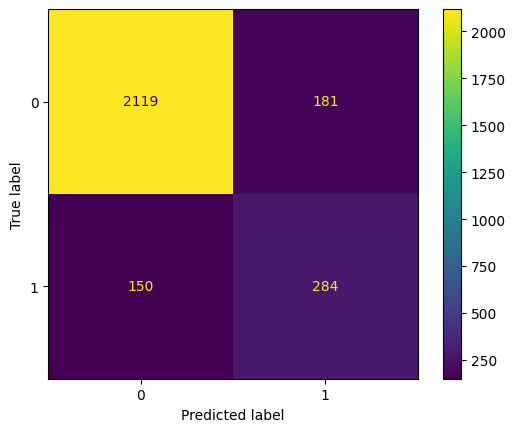

In [ ]:
metricas(predicoesGNB, 'NB Gaussiano')

In [ ]:
#Naive Bayes Bernoulli

bnb = BernoulliNB()
PipeBNB = Pipeline(steps = [('Scaler', SS), ('BNB', bnb)])

PipeBNB.fit(X_train, y_train)

predicoesBNB = PipeBNB.predict(X_test)
predicoesBNB_prob = PipeBNB.predict_proba(X_test)

Prevalência: 0.15874177029992684
Acurácia: 0.8697878566203365
Taxa de falsos positivos: 0.08260869565217391
Taxa de verdadeiros negativos (Especificidade): 0.9173913043478261
Taxa de verdadeiros positivos (Recall): 0.6175115207373272
Taxa de falsos negativos: 0.3824884792626728
False omission rate: 0.07293497363796134
Valor preditivo positivo (Precisão): 0.5851528384279476
Valor preditivo negativo: 0.9270650263620387
False discovery rate: 0.4148471615720524
F1 Score: 0.600896860986547


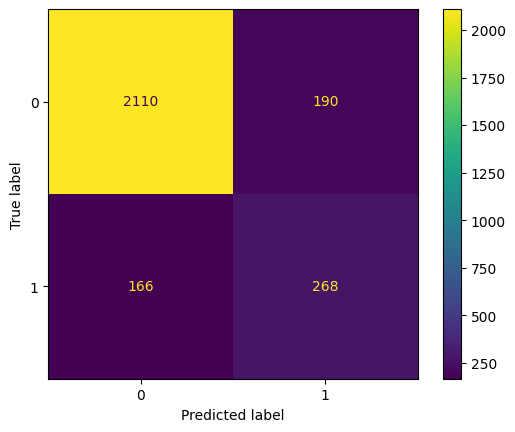

In [ ]:
metricas(predicoesBNB, 'NB Bernoulli')

In [ ]:
#LDA

clf = LDA()

PipeLDA = Pipeline(steps = [('Scaler', SS), ('LDA',clf)])

PipeLDA.fit(X_train,y_train)
predicoesLDA = PipeLDA.predict(X_test)

Prevalência: 0.15874177029992684
Acurácia: 0.9122165325530358
Taxa de falsos positivos: 0.007391304347826087
Taxa de verdadeiros negativos (Especificidade): 0.9926086956521739
Taxa de verdadeiros positivos (Recall): 0.4861751152073733
Taxa de falsos negativos: 0.5138248847926268
False omission rate: 0.08898643256185156
Valor preditivo positivo (Precisão): 0.9254385964912281
Valor preditivo negativo: 0.9110135674381484
False discovery rate: 0.07456140350877193
F1 Score: 0.6374622356495467


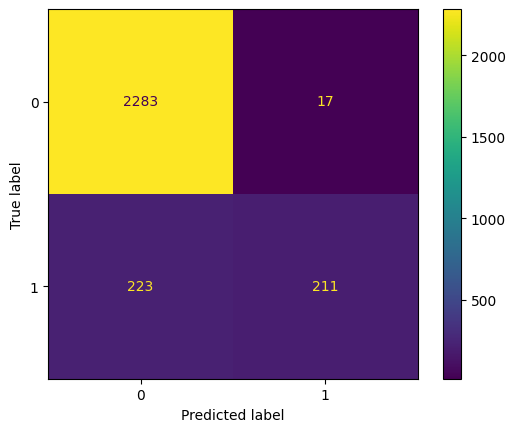

In [ ]:
metricas(predicoesLDA, 'LDA')

In [ ]:
#QDA

clf = QDA()

PipeQDA = Pipeline(steps = [('Scaler', SS), ('QDA',clf)])

PipeQDA.fit(X_train,y_train)
predicoesQDA = PipeQDA.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Prevalência: 0.15874177029992684
Acurácia: 0.24725676664228238
Taxa de falsos positivos: 0.888695652173913
Taxa de verdadeiros negativos (Especificidade): 0.11130434782608696
Taxa de verdadeiros positivos (Recall): 0.967741935483871
Taxa de falsos negativos: 0.03225806451612903
False omission rate: 0.05185185185185185
Valor preditivo positivo (Precisão): 0.17045454545454544
Valor preditivo negativo: 0.9481481481481482
False discovery rate: 0.8295454545454546
F1 Score: 0.2898550724637681


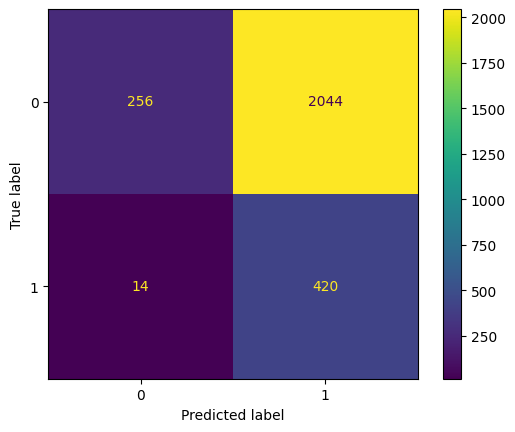

In [ ]:
metricas(predicoesQDA, 'QDA')

In [ ]:
#SVM Linear

param_lin = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 150, 200]}]
svm_lin_CV = GridSearchCV(SVC(kernel = 'linear'), param_grid = param_lin, cv = 5, scoring = 'f1', verbose = 4, n_jobs = -1)

svm_lin_CV.fit(X_train, y_train)

pd.DataFrame(svm_lin_CV.cv_results_)

svm_lin_CV.best_estimator_

predicoesSVM = svm_lin_CV.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Prevalência: 0.15874177029992684
Acurácia: 0.9122165325530358
Taxa de falsos positivos: 0.012608695652173913
Taxa de verdadeiros negativos (Especificidade): 0.9873913043478261
Taxa de verdadeiros positivos (Recall): 0.5138248847926268
Taxa de falsos negativos: 0.4861751152073733
False omission rate: 0.08501208702659147
Valor preditivo positivo (Precisão): 0.8849206349206349
Valor preditivo negativo: 0.9149879129734085
False discovery rate: 0.11507936507936507
F1 Score: 0.6501457725947521


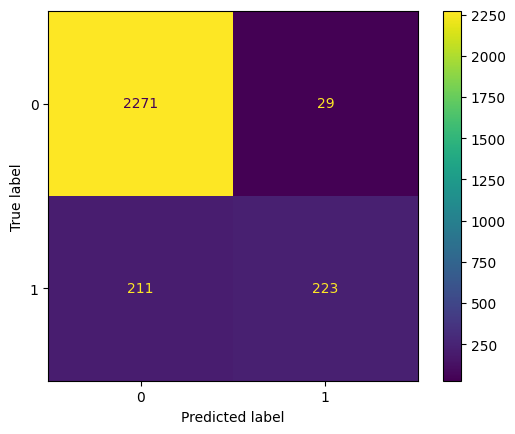

In [ ]:
metricas(predicoesSVM, 'SVM')

In [ ]:
#KNN

KNN = KNeighborsClassifier()
params = [{'leaf_size': np.linspace(1, 100, 5, dtype = int)}]
KNN_CV = GridSearchCV(KNN, param_grid = params, cv = 5, scoring = 'accuracy', n_jobs = -1)

KNN_CV.fit(X_train, y_train)
KNN_CV.best_estimator_
predicoesKNN = KNN_CV.predict(X_test)

Prevalência: 0.15874177029992684
Acurácia: 0.9049012435991222
Taxa de falsos positivos: 0.002173913043478261
Taxa de verdadeiros negativos (Especificidade): 0.9978260869565218
Taxa de verdadeiros positivos (Recall): 0.41244239631336405
Taxa de falsos negativos: 0.5875576036866359
False omission rate: 0.1
Valor preditivo positivo (Precisão): 0.9728260869565217
Valor preditivo negativo: 0.9
False discovery rate: 0.02717391304347826
F1 Score: 0.5792880258899675


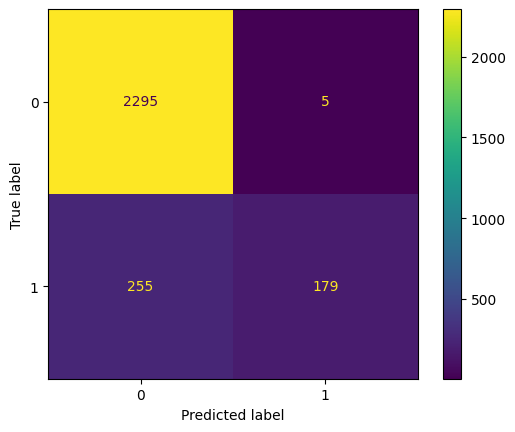

In [ ]:
metricas(predicoesKNN, 'KNN')

In [ ]:
#Decision Tree
DTC = DecisionTreeClassifier()
params = [{'min_samples_leaf': np.linspace(1, 50, 5, dtype = int)}]
DTC_CV = GridSearchCV(DTC, param_grid = params, cv = 5, scoring = 'accuracy', n_jobs = -1)

DTC_CV.fit(X_train, y_train)
predicoesDTC = DTC_CV.predict(X_test)

Prevalência: 0.15874177029992684
Acurácia: 0.8891733723482077
Taxa de falsos positivos: 0.028695652173913042
Taxa de verdadeiros negativos (Especificidade): 0.971304347826087
Taxa de verdadeiros positivos (Recall): 0.4539170506912442
Taxa de falsos negativos: 0.5460829493087558
False omission rate: 0.09591258599757184
Valor preditivo positivo (Precisão): 0.7490494296577946
Valor preditivo negativo: 0.9040874140024282
False discovery rate: 0.2509505703422053
F1 Score: 0.5652797704447633


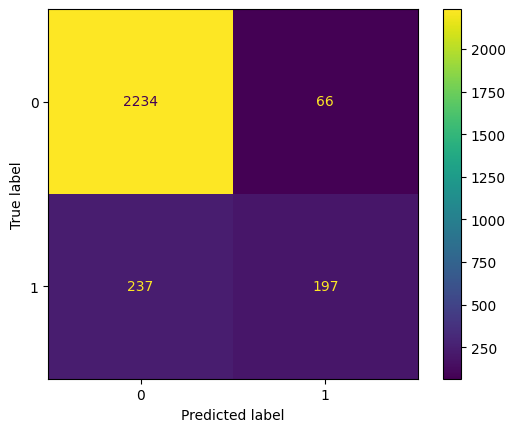

In [ ]:
metricas(predicoesDTC, 'Decision Tree')

# Conclusões

In [ ]:
Resultados = pd.DataFrame(Resultados)
Resultados

,Modelo,F1 Score,Acurácia,FP,FN
0,NB Gaussiano,0.631813,0.878932,181,150
1,NB Bernoulli,0.600897,0.869788,190,166
2,LDA,0.637462,0.912217,17,223
3,QDA,0.289855,0.247257,2044,14
4,SVM,0.650146,0.912217,29,211
5,KNN,0.579288,0.904901,5,255
6,Decision Tree,0.565280,0.889173,66,237


Sem uma busca exaustiva por hiperparâmetros melhores e de acordo com a nossa régua, o **SVM** se provou ser o melhor classificador.

Além disso, olhando para a acurácia, o LDA se saiu super bem empatando (estranhamente) com o SVM. Todos os modelos tiveram uma acurácia similar, com excessão do QDA, que foi disparadamente o pior modelo. Uma hipótese para isso é que pode ter ocorrido um overfitting no conjunto de treinamento.

Em termos de falsos positivos e negativos, o KNN tendeu a classificar a maioria das imagens como não tendo vulcões, tendo a menor taxa de falsos positivos e a maior de falsos negativos. Como a maioria das imagens de fato não tinham vulcões, obteve uma acurácia alta, porém o segundo pior F1 Score, atrás apenas do Decision Tree.